In [19]:
import re
import random
import pandas as pd
import hashlib

In [20]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()  # Truncate to first 12 characters


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

if cards_to_age['age'].sum() > 2e4: age_factor = 1
else: age_factor = 1.00

cards_to_age['age'] = cards_to_age['age'].fillna(0)
cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.60) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(.5) for _ in cards_to_age.index]


cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('age')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [21]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,head_count
Terraform,49.363780,1.974551,25
Search Engine Optimization,613.632468,102.272078,6
FSLogix,680.927136,28.371964,24
Powershell,681.023689,56.751974,12
Audit Report Tracker (Sharepoint List),905.066245,56.566640,16
Azure Functions + Visual Studio,909.533715,64.966694,14
Email Auth and Security,927.346073,71.334313,13
OData,1069.192636,71.279509,15
DNS,1071.937675,66.996105,16
JavaScript Concepts,1104.643989,15.558366,71


# Histogram

39547.35


<Axes: >

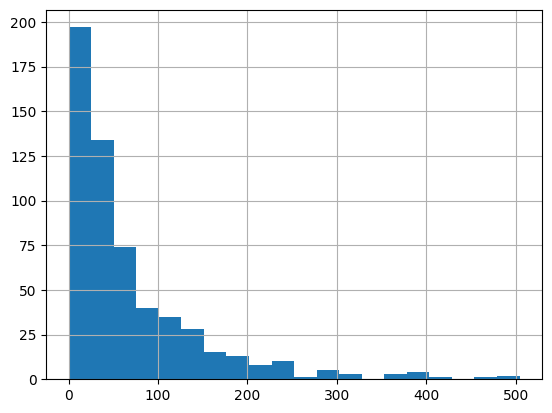

In [22]:
print(f"{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

# Completely Random Shuffle

In [23]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [24]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# Headers with fewest notes first

In [25]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# existing_cards.head(10)

# Focus on one header

In [26]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Header with oldest cards first

In [27]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest mean card age first

In [28]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest age sum first

In [29]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle

## Random

In [30]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

## Age Sum

In [31]:
# n=5
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [32]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)



## Age Max

In [33]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [34]:
n=3
existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] // n

existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
existing_cards['age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'frequency', 'age'], inplace=True)
remake_card_document(existing_cards=existing_cards)

existing_cards.head(10)



Cards found: 574


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,frequency,count,n_fold
0,Search Engine Optimization,"Domain Authority (DA), developed by Moz, is a ...",1d9f6283a52192064acd590f8da70bc7,-358.683422,-102.272078,358.683422,613.632468,0.763691,6,0,0
1,Search Engine Optimization,Link equity refers to the value or authority p...,ce2ca16db51c1a8517bb9479cb67c9ff,-82.242963,-102.272078,358.683422,613.632468,0.763691,6,1,0
2,Search Engine Optimization,An XML sitemap is a file that lists all the im...,5ee51c940547878d68b1599c861a308d,-58.383879,-102.272078,358.683422,613.632468,0.763691,6,2,0
3,Vocab,Lacunary\nadjective\nSPA: LACK-yoo-nary\nIPA: ...,dd5b0bcb1d9dc85857c09e77945b64c7,-241.356682,-113.752928,241.356682,1251.282207,0.395321,11,0,0
4,Vocab,Hieratic\nadjective\nSPA: hi-uh-RAT-ik\nIPA: /...,ca40d5a4cd7caf50cb01f3c6d0964e6d,-231.539790,-113.752928,241.356682,1251.282207,0.395321,11,1,0
5,Vocab,Intercalation\nnoun\nSPA: in-ter-kay-LAY-shun\...,23caa6b2b1c7d643d2da9e49a7b7a430,-216.522079,-113.752928,241.356682,1251.282207,0.395321,11,2,0
6,Powershell,-AllowClobber\nAllows overwriting of existing ...,7714f3ad42cf33e4637786d64df9b836,-201.534756,-56.751974,201.534756,681.023689,0.650290,12,0,0
7,Powershell,cmd /c\nRuns a Command Prompt command from Pow...,779ca7ad539bad6fddbfef21622f1063,-141.638002,-56.751974,201.534756,681.023689,0.650290,12,1,0
8,Powershell,Service Manager (services.msc)\nA GUI tool for...,31d581d8ea24442605e5c1c662d447b5,-104.891391,-56.751974,201.534756,681.023689,0.650290,12,2,0
9,Email Auth and Security,"DMARC (Domain-based Message Authentication, Re...",c4082220e30760d5dd1f7dae8370acc9,-237.186666,-71.334313,237.186666,927.346073,0.512148,13,0,0


In [35]:
existing_cards.head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,frequency,count,n_fold
0,Search Engine Optimization,"Domain Authority (DA), developed by Moz, is a ...",1d9f6283a52192064acd590f8da70bc7,-358.683422,-102.272078,358.683422,613.632468,0.763691,6,0,0
1,Search Engine Optimization,Link equity refers to the value or authority p...,ce2ca16db51c1a8517bb9479cb67c9ff,-82.242963,-102.272078,358.683422,613.632468,0.763691,6,1,0
2,Search Engine Optimization,An XML sitemap is a file that lists all the im...,5ee51c940547878d68b1599c861a308d,-58.383879,-102.272078,358.683422,613.632468,0.763691,6,2,0
3,Vocab,Lacunary\nadjective\nSPA: LACK-yoo-nary\nIPA: ...,dd5b0bcb1d9dc85857c09e77945b64c7,-241.356682,-113.752928,241.356682,1251.282207,0.395321,11,0,0
4,Vocab,Hieratic\nadjective\nSPA: hi-uh-RAT-ik\nIPA: /...,ca40d5a4cd7caf50cb01f3c6d0964e6d,-231.539790,-113.752928,241.356682,1251.282207,0.395321,11,1,0
5,Vocab,Intercalation\nnoun\nSPA: in-ter-kay-LAY-shun\...,23caa6b2b1c7d643d2da9e49a7b7a430,-216.522079,-113.752928,241.356682,1251.282207,0.395321,11,2,0
6,Powershell,-AllowClobber\nAllows overwriting of existing ...,7714f3ad42cf33e4637786d64df9b836,-201.534756,-56.751974,201.534756,681.023689,0.650290,12,0,0
7,Powershell,cmd /c\nRuns a Command Prompt command from Pow...,779ca7ad539bad6fddbfef21622f1063,-141.638002,-56.751974,201.534756,681.023689,0.650290,12,1,0
8,Powershell,Service Manager (services.msc)\nA GUI tool for...,31d581d8ea24442605e5c1c662d447b5,-104.891391,-56.751974,201.534756,681.023689,0.650290,12,2,0
9,Email Auth and Security,"DMARC (Domain-based Message Authentication, Re...",c4082220e30760d5dd1f7dae8370acc9,-237.186666,-71.334313,237.186666,927.346073,0.512148,13,0,0


In [36]:
existing_cards['age'].mean()

-68.8978228488652